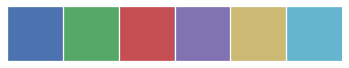

In [1]:
import edward as ed
from edward.models import Uniform
from edward.models import Bernoulli
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import matplotlib
matplotlib.interactive(True)

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()

sns.palplot(sns.color_palette())


In [2]:
# initialize a random seed for edward. Can be done ONCE only before using Edward
ed.set_seed(42)

In [3]:
VIDEO_TAG = """<video controls> 
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does noet support the video tag
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        
    return VIDEO_TAG.format(anim._encoded_video)

# Coin

In [4]:
from edward.models import Bernoulli, Beta, Empirical, Uniform

In [5]:
N = 100

In [6]:
def build_fair_dataset(N):
    pheads = tf.constant(0.5)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

In [7]:
def build_unfair_dataset(N):
    pheads = tf.constant(0.05)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

In [8]:
def build_dataset(N):
    pheads = Uniform(low=0.0,high=1.0)
    c = Bernoulli(probs=pheads, sample_shape = N)
    return sess.run([pheads, c])

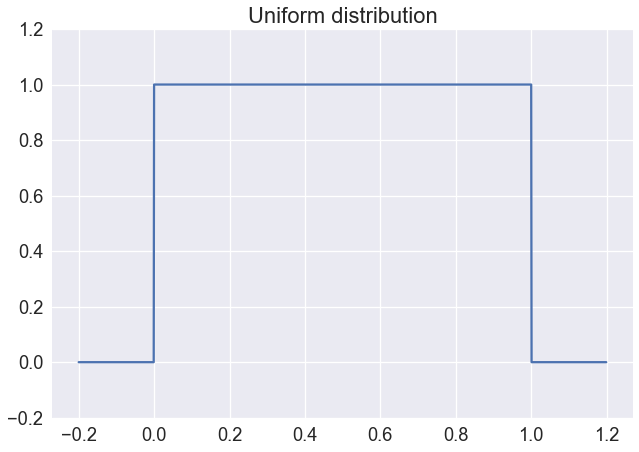

In [9]:
x = tf.range(-0.2, 1.2, 0.001)

plt.plot(*sess.run([x, Uniform(low=0.0,high=1.0).prob(x)]));
plt.ylim((-0.2,1.2))
plt.title('Uniform distribution')

In [10]:
pheads_true,c_train = build_fair_dataset(N)

In [11]:
pheads_true

0.5

In [12]:
c_train

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

In [13]:
sum(c_train == 0)

50

In [14]:
sum(c_train == 1)

50

## inference

In [15]:
# declaring priors

pheads_fair = Beta(concentration1=1000.0, concentration0=1000.0) # blue
pheads_unfair = Beta(concentration1=0.1, concentration0=0.1) # green

pheads_unknown = Beta(concentration1 = 1.0, concentration0=1.0)

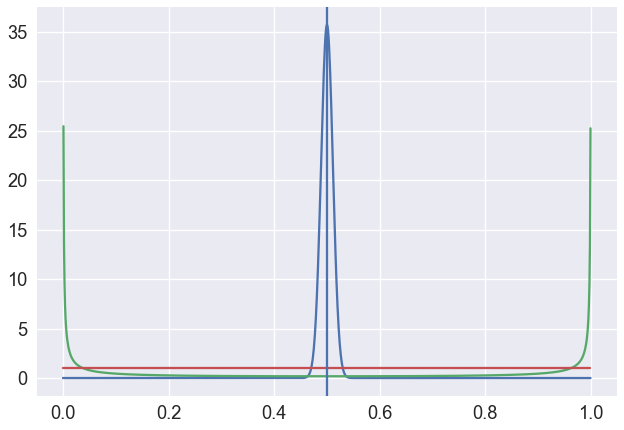

In [16]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x, pheads_fair.prob(x)]));
plt.plot(*sess.run([x, pheads_unfair.prob(x)]));
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));
plt.axvline(x=pheads_true);

In [17]:
# Forward model
pheads = pheads_unknown
c = Bernoulli(probs=pheads, sample_shape=N)

### exact solution

In [18]:
# inference
pheads_cond = ed.complete_conditional(pheads)
pheads_post = ed.copy(pheads_cond, {c: c_train})

In [19]:
sess.run({key:val for key, val in six.iteritems(pheads_post.parameters) if isinstance(val,tf.Tensor)})

{'concentration0': 51.0, 'concentration1': 51.0}

In [20]:
# criticism
mean, stddev = sess.run([pheads_post.mean(),pheads_post.stddev()])
print(" exact posterior mean: " + str(mean))
print("exact posterior std" + str(stddev))

 exact posterior mean: 0.5
exact posterior std0.0492665


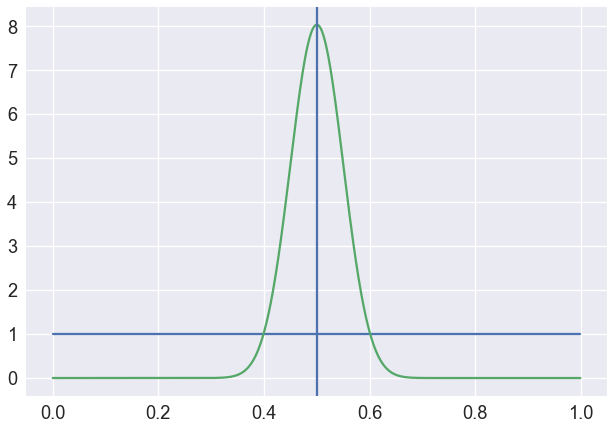

In [21]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_post.prob(x)]));
plt.axvline(x=pheads_true);

## RECURSIVE INFERENCE

finished recursion 1
finished recursion 2
finished recursion 3


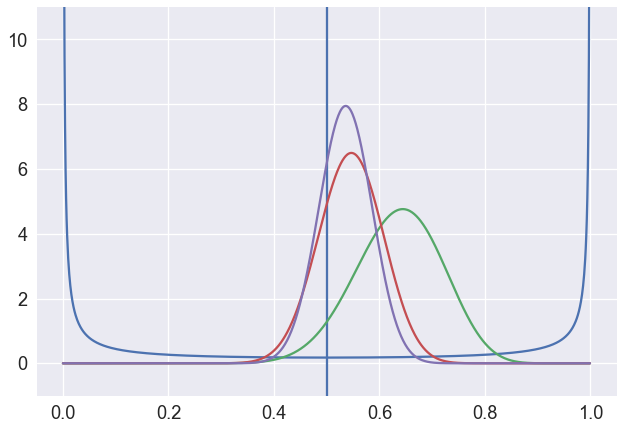

In [22]:
pheads_true,c_train = build_fair_dataset(100)

fig = plt.figure()
ax = plt.axes(xlim=(-0.05,1.05), ylim=(-1.0,11.0))

def go(pheads_prior, sample_shape, c_train, recursion=1):
    # model 
    c = Bernoulli(probs=pheads_prior,
                 sample_shape=sample_shape)
    
    # INFERENCE
    pheads_cond = ed.complete_conditional(pheads_prior)
    pheads_post = ed.copy(pheads_cond,{c:c_train[:sample_shape]})
    
    # CRITICISM
    ax.plot(*sess.run([x,pheads_post.prob(x)]));
    
    print("finished recursion "+str(recursion))
    recursion += 1
    # RECURSION
    if len(c_train[sample_shape:]) >= sample_shape:
        go(pheads_post, sample_shape, c_train[sample_shape:],recursion)
        
pheads_prior = Beta(concentration1=0.1, concentration0=0.1)
ax.plot(*sess.run([x, pheads_prior.prob(x)])); 
plt.axvline(x=pheads_true);
go(pheads_prior,33,c_train)
    
    

## approximate inference :MCMC: metroplis hastings:

In [23]:
# BACKWARD MODEL
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

In [25]:
# INFERENCE
proposal_pheads = Beta(concentration1=1.0,
                       concentration0=1.0)
inference = ed.MetropolisHastings(latent_vars = {pheads: q_pheads},
                                 proposal_vars={pheads: proposal_pheads},
                                 data={c:c_train})
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 0.164

In [28]:
# criticism
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print("inferred posterior mean:")
print(mean)
print("inferred posterior std:")
print(stddev)

inferred posterior mean:
0.536647
inferred posterior std:
0.0499241


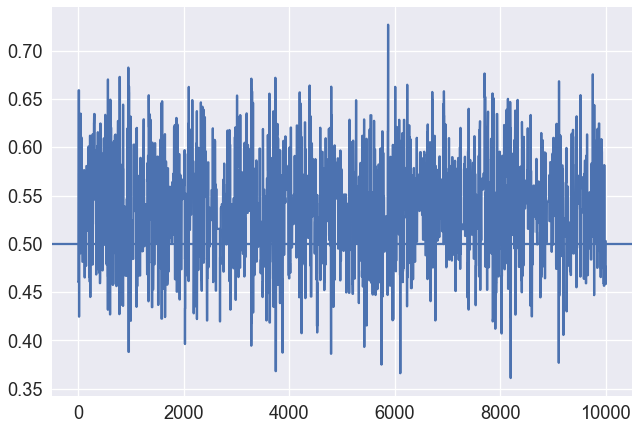

In [29]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true)

In [44]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) *tf.reduce_mean(tf.square(x-mean))
    ret = tf.map_fn(lambda k:tf.cond(tf.equal(k,0),
                                     lambda:var, 
                                     lambda:tf.reduce_sum((x[:-k] - mean) * (x[k:]-mean))),
                                     tf.range(0,tf.size(x)),
                                     dtype=tf.float32)
    return ret / var

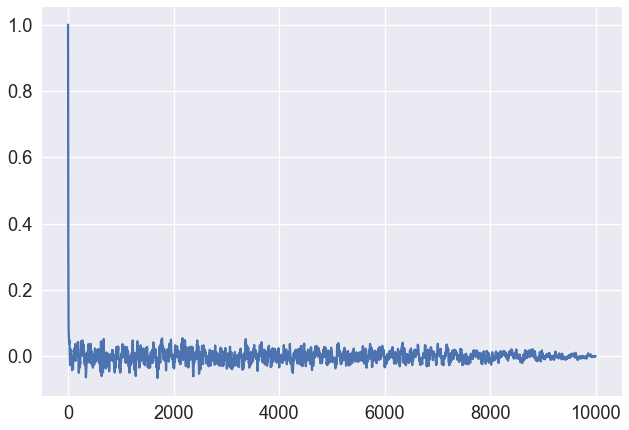

In [45]:
plt.plot(lags(q_pheads.params).eval());

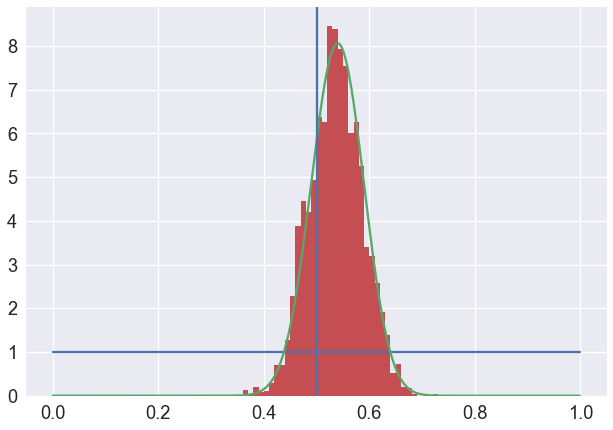

In [31]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_cond.prob(x)],
                  {c:c_train}));
plt.hist(q_pheads.params.eval(),
        bins=100,range=(0.0,1.0),
        normed = True);
plt.axvline(x=pheads_true);

## MCMC: Gibbs

In [47]:
# BACKWARD MODEL
T = 10000
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*0.5))

In [50]:
# INFERENCE 
inference = ed.Gibbs(latent_vars={pheads: q_pheads},
                    data={c: c_train})
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 18s | Acceptance Rate: 1.000

In [51]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print('Inferred posterior mean:')
print(mean)
print('Inferred posterior std:')
print(stddev)

Inferred posterior mean:
0.538878
Inferred posterior std:
0.0491835


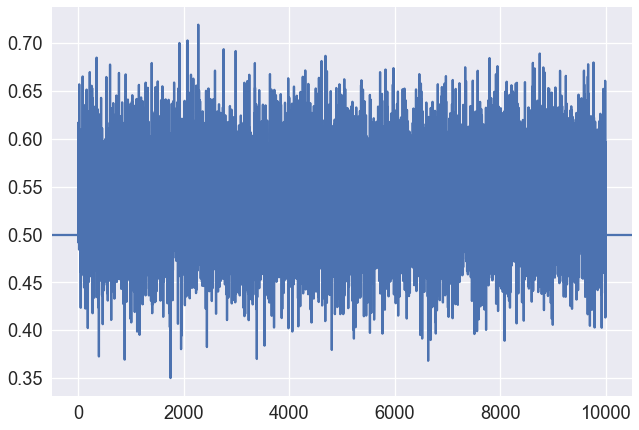

In [52]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true)

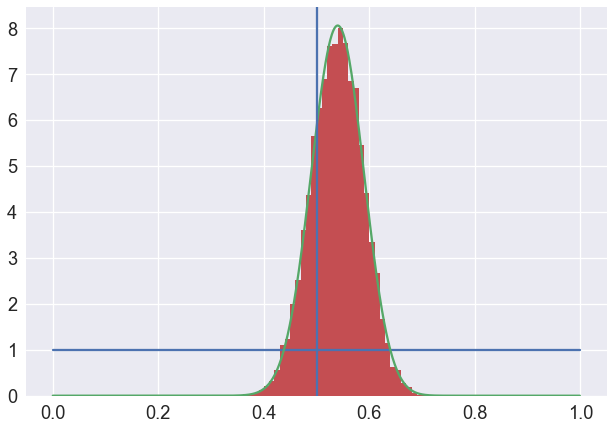

In [53]:
x = tf.range(0.0,1.0,0.001)
plt.plot(*sess.run([x,pheads.prob(x)]));
plt.plot(*sess.run([x,pheads_cond.prob(x)],
                  {c:c_train}));
plt.hist(q_pheads.params.eval(),
        bins=100,range=(0.0,1.0),
        normed = True);
plt.axvline(x=pheads_true);

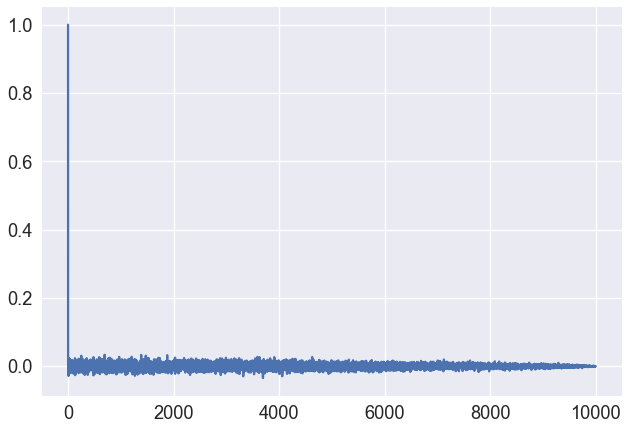

In [54]:
plt.plot(lags(q_pheads.params).eval());

## MCMC: Hamiltonian monte carlo

Metropolis hasting and Gibbs will fail in high_dimensional paramter space while HMC will not. 

HMC unitlises the geometry of the important regions of the posterior (where the probability mass is concentrated) to guide the jump proposal.

For Gibbs you need to be able to derive the complete conditional algebraically. Most of the times this is not the case, so Gibbs cannot be used. Hamiltonian monte carlo does not have this restriction. However, it only works for continuous variables. This is because it works with derivatives (i.e. we need smooth functions).


In [55]:
# BACKWARD MODEL
T = 10000 # number of empirical samples
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [57]:
# INFERENCE
inference = ed.HMC(latent_vars={pheads: q_pheads},
                  data = {c: c_train})
inference.run(step_size=1.0 / N, n_steps=20)

10000/10000 [100%] ██████████████████████████████ Elapsed: 74s | Acceptance Rate: 0.998

In [58]:
# criticism
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev")
print(stddev)

Inferred posterior mean:
0.539722
Inferred posterior stddev
0.0492454


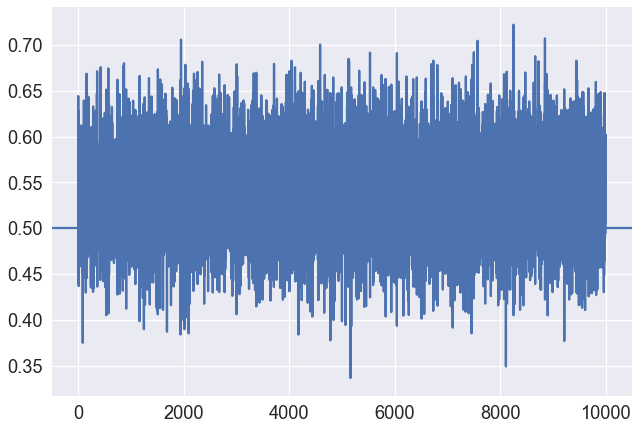

In [60]:
plt.plot(q_pheads.params.eval())
plt.axhline(y=pheads_true)

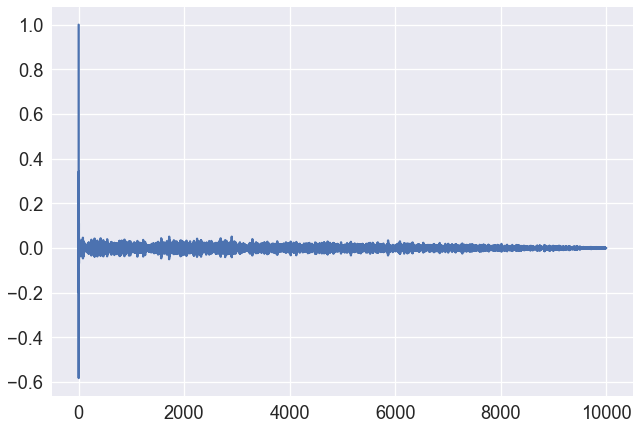

In [61]:
plt.plot(lags(q_pheads.params).eval())

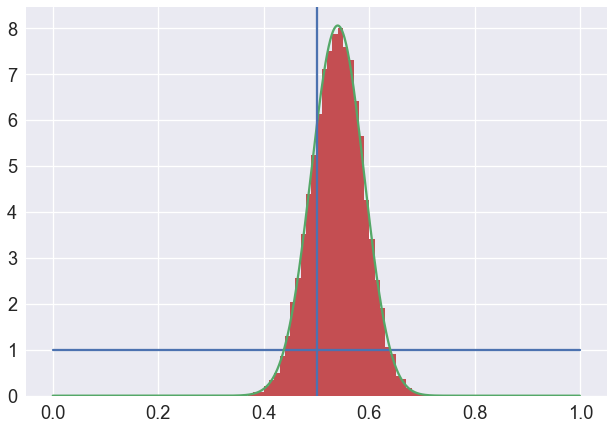

In [62]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]))
plt.plot(*sess.run([x, pheads_cond.prob(x)],
                  {c:c_train}))
plt.hist(q_pheads.params.eval(),
        bins=100, range=(0.0, 1.0),
        normed=True)
plt.axvline(x=pheads_true)

## variational inference (VI)

Good alternative to markov chain monte carlo methods. Class of algorithm that cast posterior inference as optimisation:

Approximate the model paramters, that is, the posterior p(params|data = obs):

a. build a variational backward model, q(params: lambda), over the params with some variational paramters lambda.

b. Match q(params; lambda) to p(params|obs) by optimising over lambda, 

lambda* = argmin Closeness(p(params|obs), q(params;lambda))

c. use q(params;lambda*) instead of p(params|obs)

d. criticise the variational model, revise it (-->a)

In [70]:
# BACKWARD MODEL
q_pheads_concentration1 = tf.nn.softplus(tf.Variable(51+ tf.random_normal([])))
q_pheads_concentration0 = tf.nn.softplus(tf.Variable(51+ tf.random_normal([])))
q_pheads = Beta(concentration1=q_pheads_concentration1,
               concentration0=q_pheads_concentration0)

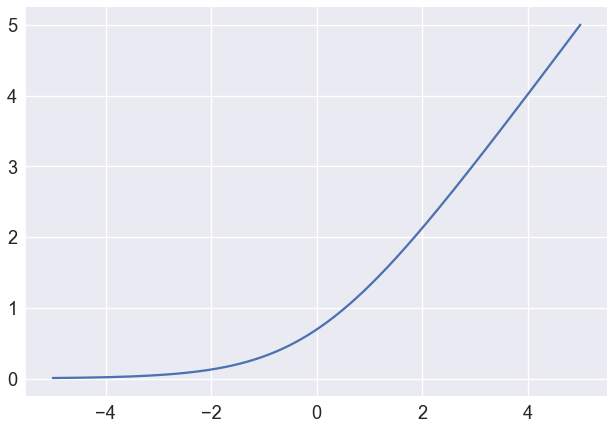

In [71]:
x = tf.range(-5.0, 5.0, 0.001)
plt.plot(*sess.run([x,tf.nn.softplus(x)]))

In [72]:
# inference
inference = ed.KLqp(latent_vars={pheads: q_pheads},
                   data={c:c_train})
inference.run(n_samples=20, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 28s | Loss: 71.154

In [73]:
sess.run({key: val for key, val in six.iteritems(q_pheads.parameters) if isinstance(val,tf.Tensor)})

{'concentration0': 46.225704, 'concentration1': 57.310051}

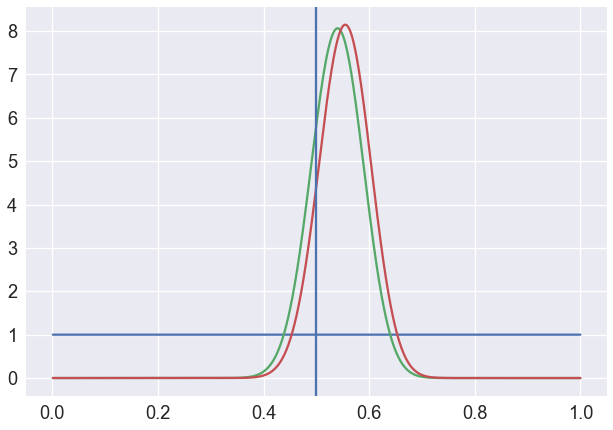

In [74]:
plt.plot(*sess.run([x,pheads.prob(x)]))
plt.plot(*sess.run([x, pheads_cond.prob(x)],
                  {c:c_train}))
plt.plot(*sess.run([x, q_pheads.prob(x)]))
plt.axvline(x=pheads_true)

In [75]:
# criticism
mean, stddev = sess.run([q_pheads.mean(),q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev")
print(stddev)

Inferred posterior mean:
0.553529
Inferred posterior stddev
0.0486222


In [76]:
## A/B/... Testing

# Bayesian linear regression